In [1]:
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2
import scipy.ndimage

Show inputs


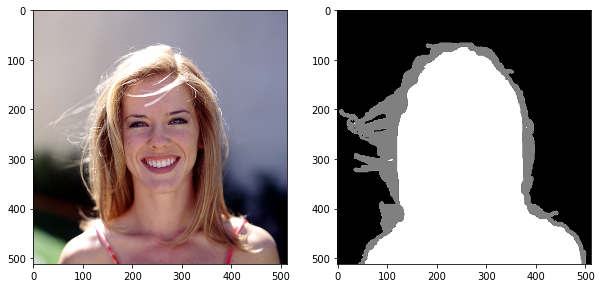

In [2]:
'''
Obtaining gray scale image from original image
'''

orig = imageio.imread('input/woman.png')
gray = imageio.imread('input/woman.png',as_gray='True')
tri = imageio.imread('input/woman-trimap.png',as_gray = 'True')
h,w = gray.shape

print("Show inputs")
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.subplot(122)
plt.imshow(tri,cmap='gray')
plt.show()

In a trimap, Background has value = 0. Foreground has value = 255. Middle portions have a value = 127.
We can approximate foreground and background in unknown region by correspponding nearest known pixel.

Show fg and bg and mid


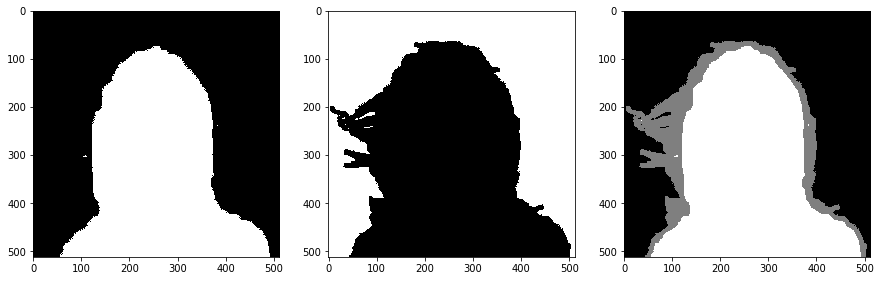

In [3]:
'''
Obtaining masks for fg(I=1 or 255), bg(I=0) and mid regions using trimap
'''

fg = tri == 255
bg = tri == 0
mid = np.zeros(tri.shape)
for i in range(mid.shape[0]):
    for j in range(mid.shape[1]):
        if(tri[i,j] != 0 and tri[i,j] != 255):
            mid[i,j] = 127
        if(tri[i,j] != 0 and tri[i,j] > 200):
            mid[i,j] = 255

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,cmap='gray')
plt.subplot(132)
plt.imshow(bg,cmap='gray')
plt.subplot(133)
plt.imshow(mid,cmap='gray')
plt.show()

We multiply the respective masks with the Gray image to get composite versions. The 'mid' image is a mask which shows the background pixels with intensity = 0, foreground with intensity = 1, and unknown pixels with intensity = 0.5.

Show fg and bg and mid


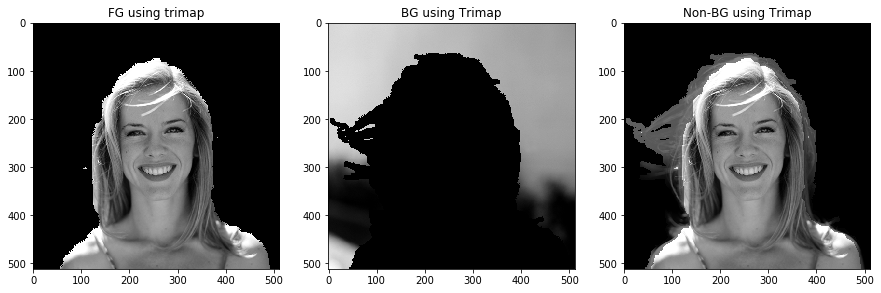

In [4]:
'''
Using masks, we obtain approximate foreground, background and non-background images using fg, bg and mid masks
'''

gray_fg = gray * fg
gray_bg = gray * bg
non_bg = gray * mid

print("Show fg and bg and mid")
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(gray_fg,cmap='gray')
plt.title("FG using trimap")
plt.subplot(132)
plt.imshow(gray_bg,cmap='gray')
plt.title("BG using Trimap")
plt.subplot(133)
plt.imshow(non_bg,cmap='gray')
plt.title("Non-BG using Trimap")
plt.show()

Generation of an estimate alpha matte 

First, the unknown region (not fg or bg) is found 

Then ,the pixels belonging to the unknown region is multiplied with an intensity of 0.5 and added to the fg to get an estimate alpha matte 

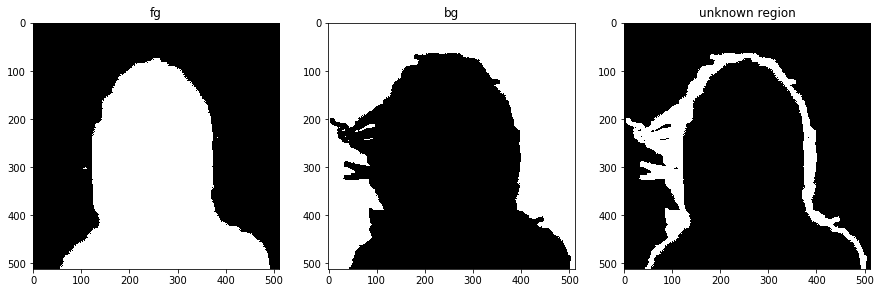

In [5]:
'''
Obtaining unknown region using the foreground and background masks 
'''

unknown = True ^ np.logical_or(fg,bg)

fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(fg,'gray')
plt.title('fg')
plt.subplot(132)
plt.imshow(bg,'gray')
plt.title('bg')
plt.subplot(133)
plt.imshow(unknown,'gray')
plt.title('unknown region')
plt.show()


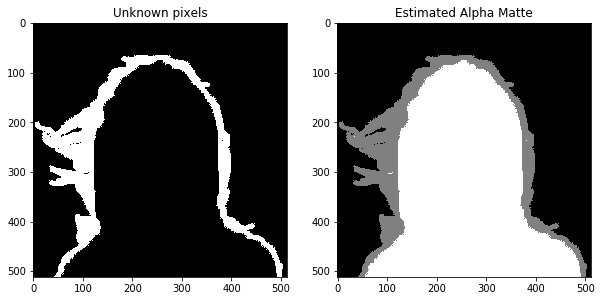

In [6]:
'''
Estimating Alpha matte using the masks for fg and unknown regions
'''

Estimate_alpha = fg + 0.5 * unknown

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(unknown,'gray')
plt.title('Unknown pixels')
plt.subplot(122)
plt.imshow(Estimate_alpha,'gray')
plt.title('Estimated Alpha Matte')
plt.show()

Generating Approximate Background and Foreground in the unknown region by checking the nearest neighbouring pixels

In [7]:
'''
Inpainting approximate fg and bg images
'''

not_fg = np.logical_not(fg)
bg_approx = cv2.inpaint(gray_bg.astype(np.uint8),(unknown + fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_fg
bg_approx = bg_approx.astype(np.float32)
not_bg = np.logical_not(bg)
fg_approx = cv2.inpaint(gray_fg.astype(np.uint8),(unknown + bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*not_bg
fg_approx = fg_approx.astype(np.float32)

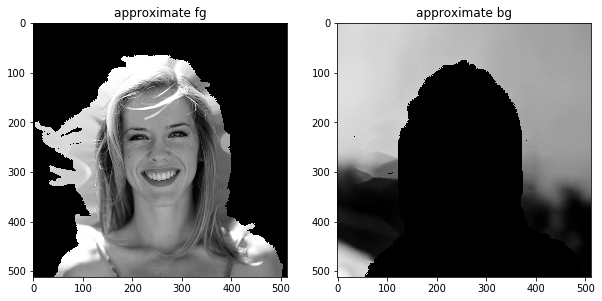

In [8]:
'''
Plotting approximate fg and bg
'''

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(fg_approx,'gray')
plt.title('approximate fg')
plt.subplot(122)
plt.imshow(bg_approx,'gray')
plt.title('approximate bg')
plt.show()

Using Poisson Equations, Reconstructing the Alpha matte

We use the gradient field of alpha matte to estimate the alpha matte

Finding the approximate matte gradient field

$$\Delta \alpha = div \frac{\nabla I}{F-B}$$

First, we find the approximate F-B 

In [9]:
'''
Finding F-B using approximate fg and bg images
'''

diff_approx = fg_approx - bg_approx
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)



Modifying the approximate F-B

In [10]:
diff_approx = scipy.ndimage.filters.gaussian_filter(diff_approx, 0.9)
diff_new = np.maximum(diff_approx,0)
diff_new = np.minimum(diff_new,255)



Then, we find the approximate gradient matte using the divergence operator

In [11]:
'''
Finding the gradient alpha matte 
'''

dy, dx = np.gradient(gray)
d2y, _ = np.gradient(dy/diff_approx)
_, d2x = np.gradient(dx/diff_approx)

b = d2y + d2x

/Users/GowriL/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1091: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':


Reconstructing alpha matte using the approximate gradient field(b) and Estimated alpha matte

We find the alpha matte by solving the laplacian

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ae5cade73b31dee0e04eb21b1e6e13b5944ef41)

We use the Gauss-Seidel iteration for this
![ig](https://wikimedia.org/api/rest_v1/media/math/render/svg/02f26444f4da61ae84a9824a6b5292949a483fcc)

In [12]:
def Alpha_matte_slow(alpha, b):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    
    iterations = 1
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    new_alpha[i,j] = 1/4  * (new_alpha[i-1 ,j] + new_alpha[i,j-1] + old_alpha[i, j+1] + old_alpha[i+1,j] - b[i,j])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha

In [13]:
New_alpha_slow = Alpha_matte_slow(Estimate_alpha, b)

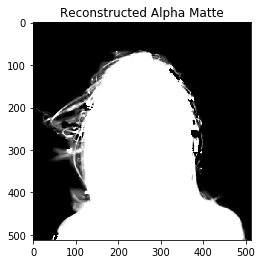

In [14]:
New_alpha_slow = np.maximum(New_alpha_slow,0)
New_alpha_slow = np.minimum(New_alpha_slow,1)
New_alpha_slow = New_alpha_slow.reshape(h,w)

plt.imshow(New_alpha_slow, cmap='gray')
plt.title("Reconstructed Alpha Matte")
plt.show()

# Using an optimised method to find Alpha matte 

In [15]:
def opt_Alpha_matte_fast(alpha,b, unknown_seg):
    new_alpha = alpha.copy()
    old_alpha = np.zeros(new_alpha.shape)
    
    threshold = 0.1
    max_iterations = 50
    non_zero = np.nonzero(unknown_seg)
    
    iterations = 1
    ca = np.transpose(non_zero)
    c = ca[(ca[:,0]>=1)&(ca[:,0]<h-1)&(ca[:,1]>=1)&(ca[:,1]<w-1)]
    c0 = c[:,0]
    c1 = c[:,1]
    change = np.sum(np.abs(new_alpha - old_alpha))
    while (iterations < max_iterations and change > threshold):
        old_alpha = new_alpha.copy()
        new_alpha[c0,c1] = 1/4  * (new_alpha[c0-1 ,c1] + new_alpha[c0,c1-1] + old_alpha[c0, c1+1] + old_alpha[c0+1,c1] - b[c0,c1])
        iterations = iterations + 1
        change = np.sum(np.abs(new_alpha - old_alpha))
    return new_alpha   

Comparing the time difference between optimised and slow version 

In [16]:
print('Time taken using previous method: ')
%timeit Alpha_matte_slow(Estimate_alpha, b)
print('Time taken using optimized method: ')
%timeit opt_Alpha_matte_fast(Estimate_alpha, b, unknown)

Time taken using previous method: 
3.32 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Time taken using optimized method: 
72.6 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
New_alpha = opt_Alpha_matte_fast(Estimate_alpha, b,unknown)
New_alpha = np.maximum(New_alpha,0)
New_alpha = np.minimum(New_alpha,1)
New_alpha = New_alpha.reshape(h,w)

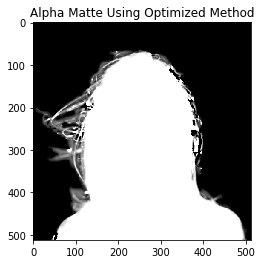

In [18]:
plt.imshow(New_alpha, cmap='gray')
plt.title("Alpha Matte Using Optimized Method")
plt.show()

## Generating final image using chroma-keying

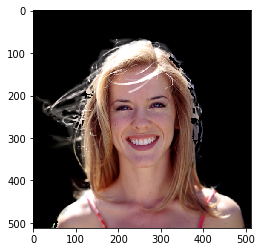

In [19]:
'''
Obtaining foreground image using the alpha matte found above
'''

new_fg = (New_alpha.reshape(h,w,1).repeat(3,2)*orig).astype(np.uint8)
plt.imshow(new_fg,cmap='gray')
bg = imageio.imread('input/bg.jpg')
bg = np.asarray(bg)
res = np.zeros(new_fg.shape)

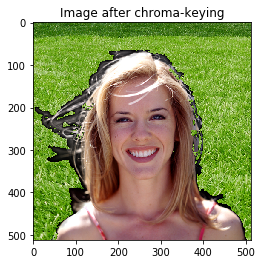

In [20]:
'''
Chroma Keying
'''

new_fg_arr = np.asarray(new_fg)
for i in range(new_fg.shape[0]):
    for j in range(new_fg.shape[1]):
        if(i<new_fg_arr.shape[0] and j<new_fg_arr.shape[1]):
            if(new_fg_arr[i,j,0] == 0 and new_fg_arr[i,j,1] == 0 and new_fg_arr[i,j,2] == 0):
                res[i,j,0] = bg[i,j,0]
                res[i,j,1] = bg[i,j,1]
                res[i,j,2] = bg[i,j,2]
            else:
                res[i,j,0] = new_fg_arr[i,j,0]
                res[i,j,1] = new_fg_arr[i,j,1]
                res[i,j,2] = new_fg_arr[i,j,2]
        else:
            res[i,j,0] = bg[i,j,0]
            res[i,j,1] = bg[i,j,1]
            res[i,j,2] = bg[i,j,2]
            
res = res.astype(np.uint8)
res_image = Image.fromarray(res)
plt.imshow(res)
plt.title('Image after chroma-keying')
plt.show()

# Generating Final Image using Alpha Blending

### I = α F + (1 − α )B

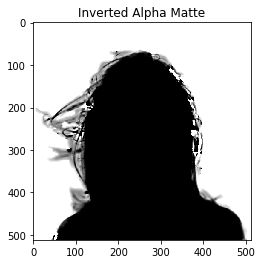

In [21]:
'''
Finding 1-alpha
'''

inverted_alpha = 1 - New_alpha

plt.imshow(inverted_alpha, cmap='gray')
plt.title("Inverted Alpha Matte")
plt.show()

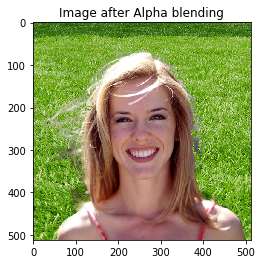

In [22]:
'''
Alpha Blending
'''

bg_new = imageio.imread('input/bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final = np.zeros(bg_new.shape)

final[:, :, 0] = New_alpha * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final[:, :, 1] = New_alpha * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final[:, :, 2] = New_alpha * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

plt.imshow(final/255)
plt.title("Image after Alpha blending")
plt.show()

## Local Poisson Matting

In [23]:
def local_poisson_matte(starth, endh, startw, endw):
    local_matte = np.zeros((h,w))

    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)


    seg1 = gray[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]

    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx20)
    _, d2xfg = np.gradient(dxfg/diff_approx20)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx20)
    _, d2xbg = np.gradient(dxbg/diff_approx20)


    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx20)
    _, d2x = np.gradient(dx/diff_approx20)


    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = New_alpha[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg

    b_seg = d2y + d2x -(Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))


    matte = opt_Alpha_matte_fast(Estimate_alpha_seg, b_seg,unknown_seg)
    return matte

In [24]:
'''
Manually selecting regions and performing local poisson matting on them
'''
new_local_matte = np.zeros_like(gray)

for i in range(0,h):
    for j in range(0,w):
        new_local_matte[i, j] = New_alpha[i,j]
        
starth = 100
endh = 400
startw = 300
endw = 450
new_local_matte[starth:endh+1,startw:endw+1] = local_poisson_matte(starth, endh, startw, endw)

In [25]:
new_local_matte = np.maximum(new_local_matte,0)
new_local_matte = np.minimum(new_local_matte,1)
new_local_matte = new_local_matte.reshape(h,w)

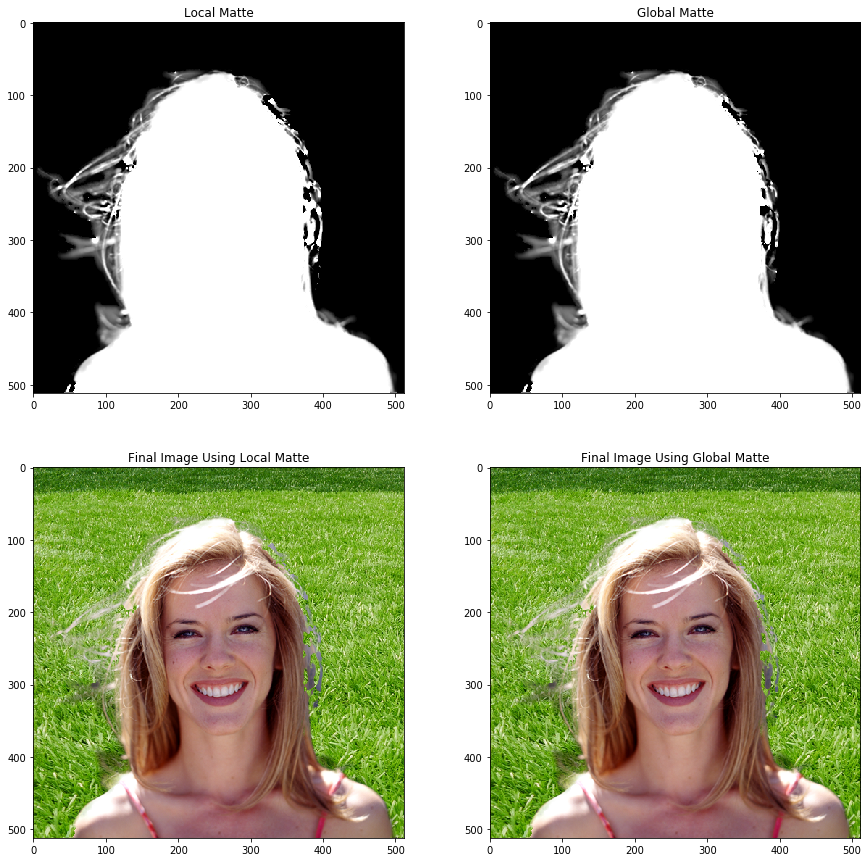

In [26]:
'''
Comparing Local Poisson Matting and Global Poisson Matting Results
'''

bg_new = imageio.imread('input/bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alpha = 1 - new_local_matte

final_seg[:, :, 0] = new_local_matte * orig[:, :, 0] + inverted_alpha * bg_new[:, :, 0] 
final_seg[:, :, 1] = new_local_matte * orig[:, :, 1] + inverted_alpha * bg_new[:, :, 1] 
final_seg[:, :, 2] = new_local_matte * orig[:, :, 2] + inverted_alpha * bg_new[:, :, 2] 

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(new_local_matte,cmap='gray')
plt.title("Local Matte")
plt.subplot(222)
plt.imshow(New_alpha,cmap='gray')
plt.title("Global Matte")
plt.subplot(223)
plt.imshow(final_seg/255)
plt.title("Final Image Using Local Matte")
plt.subplot(224)
plt.imshow(final/255)
plt.title("Final Image Using Global Matte")
plt.show()

# Refining the alpha matte

In [27]:
'''
Boosting Brush
'''

def boosting(alpha_matte,starth, endh, startw, endw):

    local_matte = np.zeros((h,w))
    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
    mh = endh - starth +1
    mw = endw-startw +1

    seg1 = gray[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]
    
    A = np.zeros((h,w))
    lambda_ = 5
    sigma = 20
    x0 = starth + mh/2
    y0 = startw + mw/2
    
    for x in range(starth,endh+1+1):
        for y in range(startw,endw+1+1):
            A[x,y] = (1 + lambda_*np.exp(-1*((abs(x-x0)**2+(abs(y-y0))**2))/(2*sigma**2)))*(1/diff_approx[x,y])
    diff_approx2 = 1/A[starth:endh+1,startw:endw+1]
    
    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx2)
    _, d2xfg = np.gradient(dxfg/diff_approx2)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx2)
    _, d2xbg = np.gradient(dxbg/diff_approx2)

    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx2)
    _, d2x = np.gradient(dx/diff_approx2)

    
    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = alpha_matte[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))
    
    b_seg1 = d2y + d2x - D
    matte1 = opt_Alpha_matte_fast(Estimate_alpha_seg, b_seg1,unknown_seg)
    
    return matte1


In [28]:
'''
Local High Pass Filter
'''

def high_pass(alpha_matte,starth, endh, startw, endw):
    local_matte = np.zeros((h,w))
    diff_approx20 = diff_approx[starth:endh+1,startw:endw+1]
    diff_approx20 = scipy.ndimage.filters.gaussian_filter(diff_approx20, 0.9)
    mh = endh - starth +1
    mw = endw-startw +1

    seg1 = gray[starth:endh+1,startw:endw+1]

    fg_approx_seg = fg_approx[starth:endh+1,startw:endw+1]
    bg_approx_seg = bg_approx[starth:endh+1,startw:endw+1]
    
    dyfg, dxfg = np.gradient(fg_approx_seg)
    d2yfg, _ = np.gradient(dyfg/diff_approx20)
    _, d2xfg = np.gradient(dxfg/diff_approx20)

    dybg, dxbg = np.gradient(bg_approx_seg)
    d2ybg, _ = np.gradient(dybg/diff_approx20)
    _, d2xbg = np.gradient(dxbg/diff_approx20)

    dy, dx = np.gradient(seg1)
    d2y, _ = np.gradient(dy/diff_approx20)
    _, d2x = np.gradient(dx/diff_approx20)

    unknown_seg = unknown[starth:endh,startw:endw]
    Estimate_alpha_seg = alpha_matte[starth:endh+1,startw:endw+1]
    inverted_alpha_seg = 1 - Estimate_alpha_seg
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + inverted_alpha_seg*(d2ybg+d2xbg))
    
    refined_D = cv2.GaussianBlur(seg1,(3,3),0)
    b_seg = d2y + d2x - refined_D
    matte = opt_Alpha_matte_fast(Estimate_alpha_seg, b_seg,unknown_seg)
    
    return matte

In [29]:
'''
Performing Local Filter Operations on user selected regions and Obtaining the refined alpha Matte
'''

new_local_matte = np.zeros_like(gray)

for i in range(0,h):
    for j in range(0,w):
        new_local_matte[i, j] = New_alpha[i,j]


starth = 120
endh = 380
startw = 320
endw = 400
new_local_matte[starth:endh+1,startw:endw+1] = high_pass(new_local_matte,starth, endh, startw, endw)


starth = 300
endh = 450
startw = 50
endw = 150
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

starth = 50
endh =150
startw = 150
endw = 310
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)


starth = 350
endh = 450
startw = 400
endw = 450
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

starth = 300
endh = 330
startw = 0
endw = 90
new_local_matte[starth:endh+1,startw:endw+1] = boosting(new_local_matte,starth, endh, startw, endw)

/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/Users/GowriL/anaconda3/lib/python3.7/site-packages

In [30]:
new_local_matte = np.maximum(new_local_matte,0)
new_local_matte = np.minimum(new_local_matte,1)
new_local_matte = new_local_matte.reshape(h,w)

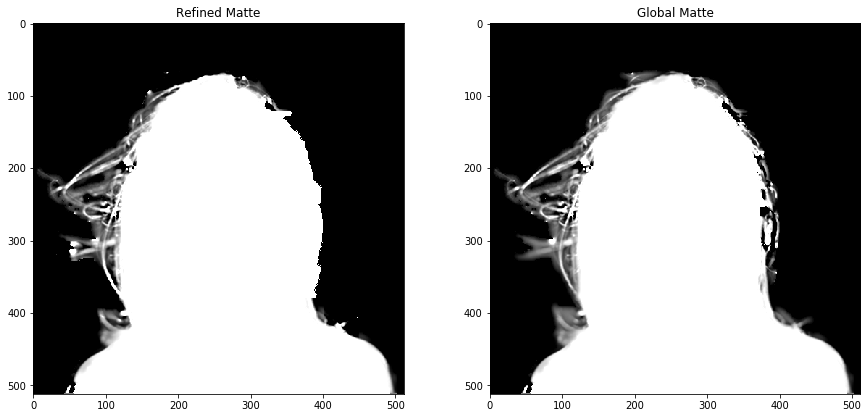

In [31]:
'''
Comparing Refined Alpha matte and Global Alpha matte
'''

bg_new = imageio.imread('input/bg.jpg')
bg_new = bg_new[0:h, 0:w, :]
final_seg = np.zeros(bg_new.shape)
inverted_alphal = 1 - new_local_matte

final_seg[:, :, 0] = new_local_matte * orig[:, :, 0] + inverted_alphal * bg_new[:, :, 0] 
final_seg[:, :, 1] = new_local_matte * orig[:, :, 1] + inverted_alphal * bg_new[:, :, 1] 
final_seg[:, :, 2] = new_local_matte * orig[:, :, 2] + inverted_alphal * bg_new[:, :, 2] 

fig = plt.figure(figsize=(15,15))

plt.subplot(221)
plt.imshow(new_local_matte,cmap='gray')
plt.title("Refined Matte")
plt.subplot(222)
plt.imshow(New_alpha,cmap='gray')
plt.title("Global Matte")
plt.show()

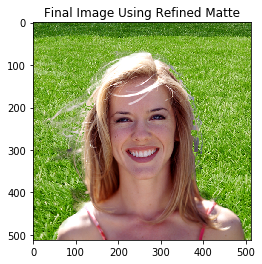

In [32]:
'''
Final refined image on a new background
'''
plt.imshow(final/255)
plt.title("Final Image Using Refined Matte")
plt.show()